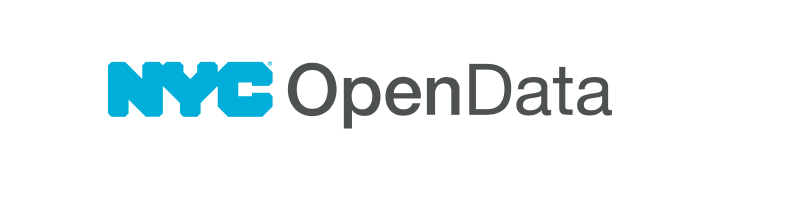

***


# NYC 311 Tree Requests

## Initial Setup and Dataframe
***
First, we imported the necessary libraries and entered our app token, data set ID, and other necessary information to retrieve data using the Socrata/sodapy module.  
The results are then stored in a dataframe.

In [1]:
import os
import csv
import pandas as pd
from sodapy import Socrata
from datetime import datetime

In [2]:
data_url='data.cityofnewyork.us' 
data_set='erm2-nwe9'
app_token='OaDaDFKhUvsnpwRgJBNoStfYZ'
client = Socrata(data_url,app_token)  
client.timeout = 60
results = client.get(data_set, limit=200000)
df = pd.DataFrame.from_records(results)

## Extracting New Tree Requests from the 311 Dataset
***

In [3]:
metadata = client.get_metadata(data_set)
[x['name'] for x in metadata['columns']]
new_trees = client.get(data_set, where="Complaint_Type = 'New Tree Request' ", limit=200000)
new_trees_df = pd.DataFrame.from_records(new_trees)

### Data Cleansing
Next, we extracted the necessary columns from our dataframe: 

In [4]:
new_trees_df = new_trees_df.drop(columns=['agency', 'agency_name', 'descriptor', 'location_type','incident_address', 'street_name','park_borough','city','facility_type', 'closed_date', 'landmark', 'location','x_coordinate_state_plane','bbl','community_board','resolution_action_updated_date','resolution_description', 'due_date','cross_street_1', 'cross_street_2', 'intersection_street_1', 'intersection_street_2','address_type','open_data_channel_type','park_facility_name','y_coordinate_state_plane'])

In [5]:
new_trees_df.shape
new_trees_df.head(10)

,unique_key,created_date,complaint_type,incident_zip,status,borough,latitude,longitude
0,39563718,2018-06-25T12:07:26.000,New Tree Request,11218,In Progress,BROOKLYN,40.63410604236388,-73.97886544147784
1,45244583,2019-12-25T08:40:04.000,New Tree Request,11201,In Progress,BROOKLYN,40.693203021574575,-73.99684467618411
2,39569182,2018-06-26T08:56:48.000,New Tree Request,11223,In Progress,BROOKLYN,40.594198472669724,-73.97391625583192
3,45245090,2019-12-25T08:40:04.000,New Tree Request,11201,In Progress,BROOKLYN,40.69316185063515,-73.99686631462531
4,45245092,2019-12-25T10:46:29.000,New Tree Request,11426,In Progress,QUEENS,40.74608794734839,-73.72753489549001
5,39478244,2018-06-16T18:56:59.000,New Tree Request,10023,Closed,MANHATTAN,40.77675732861632,-73.98131509787878
6,39484381,2018-06-16T11:40:12.000,New Tree Request,11231,Closed,BROOKLYN,40.67713487526261,-73.99172603035278
7,39493837,2018-06-18T19:18:24.000,New Tree Request,10024,Closed,MANHATTAN,40.78813737195965,-73.9700737676928
8,39503501,2018-06-19T19:51:45.000,New Tree Request,11223,In Progress,BROOKLYN,40.59067844551486,-73.96910009745238
9,39495072,2018-06-18T12:25:06.000,New Tree Request,11203,Closed,BROOKLYN,40.65221466617298,-73.9372205987594


And then exported the results to a csv file for use in BigQuery.

In [36]:
new_trees_df.to_csv("newTreeRequests.csv")

## Extracting Dead Tree Dataset
***

The process was repeated to extract the "Dead Tree", "Dying/Damaged Tree", and "Damaged Tree" requests. The Damaged Tree requests were included because many of them are actually requests for tree removal, which impacts some of our KPIs. 

In [6]:
dead_trees = client.get(data_set, where="Complaint_Type = 'Dead Tree' ", limit=200000)
dead_tree_df = pd.DataFrame.from_records(dead_trees)

In [7]:
dead_tree_df.shape

(57498, 34)

In [8]:
dead_tree_df = dead_tree_df.drop(columns=['agency', 'agency_name', 'descriptor', 'location_type','incident_address', 'street_name','park_borough','city','facility_type', 'closed_date', 'landmark', 'location','x_coordinate_state_plane','bbl','community_board','resolution_action_updated_date','resolution_description', 'due_date','cross_street_1', 'cross_street_2', 'intersection_street_1', 'intersection_street_2','address_type','open_data_channel_type','park_facility_name','y_coordinate_state_plane'])


In [9]:
dead_tree_df.shape

(57498, 8)

After consulting the data dictionary for the 311 Dataset, we found that many of the Damaged Tree Requests actually referred to a tree that was dead (or soon to be dead!) This affects our calculation of the tree population and impacts our recommendations for appropriately allocating resources in the five boroughs. In order to filter out the instances that were relevant to our KPIs, we dropped any rows containing references to damaged limbs or branches (as well as a rogue value pertaining to child care.)

In [10]:
damaged_trees = client.get(data_set, where="Complaint_Type = 'Damaged Tree'", limit=500000)
damaged = pd.DataFrame.from_records(damaged_trees)

In [11]:
damaged.shape

(395234, 34)

In [12]:
damaged = damaged[damaged["descriptor"].str.contains("Branch Cracked and Will Fall")==False]

In [13]:
damaged = damaged[damaged["descriptor"].str.contains("Branch or Limb Has Fallen Down")==False]
damaged.shape

(158667, 34)

In [14]:
damaged = damaged[damaged["descriptor"].str.contains("Tree Trunk Split")==False]
damaged.shape

(152106, 34)

Correcting a rogue value (possibly an input error):

In [15]:
damaged = damaged[damaged["descriptor"].str.contains("Child Care Information")==False]
damaged.shape

(152105, 34)

This reduced the number of rows in the "Damaged Tree" request category by 60%. Now we can proceed with dropping unnecessary rows in order to concatenate the dataframes before exporting the results to Google BigQuery. 

In [16]:
damaged = damaged.drop(columns=['agency', 'agency_name', 'descriptor', 'location_type','incident_address', 'street_name','park_borough','city','facility_type', 'closed_date', 'landmark', 'location','x_coordinate_state_plane','bbl','community_board','resolution_action_updated_date','resolution_description', 'due_date','cross_street_1', 'cross_street_2', 'intersection_street_1', 'intersection_street_2','address_type','open_data_channel_type','park_facility_name','y_coordinate_state_plane'])
damaged.shape

(152105, 8)

### Joining the datasets:
***

In [17]:
dead_dying_tree = dead_tree_df.append(damaged)

In [18]:
dead_dying_tree.shape

(209603, 8)

In [19]:
dead_dying_tree.head(10)

,unique_key,created_date,complaint_type,status,borough,incident_zip,latitude,longitude
0,29223277,2014-11-04T09:07:07.000,Dead Tree,Closed,BROOKLYN,NaN,NaN,NaN
1,29888775,2015-02-06T16:25:27.000,Dead Tree,Closed,BROOKLYN,11235,NaN,NaN
2,29910948,2015-02-10T10:33:26.000,Dead Tree,Open,QUEENS,11423,NaN,NaN
3,30345546,2015-04-06T10:04:55.000,Dead Tree,Open,BROOKLYN,NaN,NaN,NaN
4,30456052,2015-04-22T13:50:31.000,Dead Tree,Open,BROOKLYN,11219,NaN,NaN
5,30472468,2015-04-24T13:21:08.000,Dead Tree,Closed,BROOKLYN,11209,NaN,NaN
6,30510775,2015-04-29T14:24:09.000,Dead Tree,Open,BROOKLYN,NaN,NaN,NaN
7,30527031,2015-05-01T03:00:31.000,Dead Tree,Open,MANHATTAN,NaN,NaN,NaN
8,30612796,2015-05-13T14:05:35.000,Dead Tree,Open,MANHATTAN,NaN,NaN,NaN
9,30624993,2015-05-15T18:53:49.000,Dead Tree,Open,QUEENS,NaN,NaN,NaN


In [20]:
dead_dying_tree.tail(10)

,unique_key,created_date,complaint_type,status,borough,incident_zip,latitude,longitude
395213,42887988,2019-06-06T10:42:23.000,Damaged Tree,Closed,STATEN ISLAND,10314,40.594216050126846,-74.15820213852852
395215,42891941,2019-06-06T19:49:08.000,Damaged Tree,Closed,MANHATTAN,10003,40.72403183460069,-73.99027349922211
395217,42895165,2019-06-07T09:06:35.000,Damaged Tree,Closed,STATEN ISLAND,10314,40.59402693178068,-74.15800365008234
395220,43107758,2017-07-24T10:07:22.000,Damaged Tree,Assigned,QUEENS,11372,40.755311865629004,-73.88519429741868
395221,43107767,2017-07-24T12:16:59.000,Damaged Tree,Open,QUEENS,11375,NaN,NaN
395223,47040946,2020-07-30T02:02:56.000,Damaged Tree,Closed,BROOKLYN,11207,40.68262243113261,-73.8880704487505
395225,16215031,2010-03-15T15:04:06.000,Damaged Tree,Closed,BROOKLYN,11216,40.67702662934846,-73.95267801549666
395229,18342663,2010-07-26T14:12:38.000,Damaged Tree,Assigned,BRONX,10463,40.884255673730884,-73.88758632273493
395230,18696166,2010-09-16T21:12:02.000,Damaged Tree,Closed,BROOKLYN,11221,40.688370063222735,-73.94491023273594
395232,18773894,2010-09-27T11:36:47.000,Damaged Tree,Closed,QUEENS,11385,40.70334746719726,-73.85539558661452


Now the dataframe is ready to be exported as a csv file and converted into a table in Google BigQuery. 

In [87]:
dead_dying_tree.to_csv("deadTreeRequests.csv")

In [21]:
TotalTree311Requests = new_trees_df.append(dead_dying_tree)

In [22]:
TotalTree311Requests.shape

(399316, 8)

In [23]:
TotalTree311Requests.to_csv("311TreeRequests.csv")

## Extracting Tree Population Data
***
We next extracted tree population data from the 2015 "Street Tree Census" dataset available for public use in NYC OpenData. This was cleansed and filtered using the same methods we applied to the 311 Requests dataset. The tree population data is a valuable resource for identifying regions of New York City that have been historically under-resourced. We will use this data to compare against our target database to generate population percent changes over time to help the local government or city council officials determine where to apply limited resources. 

In [49]:
census2015_url='data.cityofnewyork.us' 
census2015_set='29bw-z7pj'
app_token='OaDaDFKhUvsnpwRgJBNoStfYZ'
client = Socrata(census2015_url,app_token)  
client.timeout = 60
census2015_results = client.get(census2015_set, select="status, spc_common, zipcode, borocode, boroname, latitude, longitude, objectid", limit=800000)
census_2015 = pd.DataFrame.from_records(census2015_results)

In [50]:
census_2015.columns

Index(['status', 'spc_common', 'zipcode', 'borocode', 'boroname', 'latitude',
       'longitude', 'objectid'],
      dtype='object')

In [51]:
census_2015.shape

(592372, 8)

In [52]:
census_2015.head(10)

,status,spc_common,zipcode,borocode,boroname,latitude,longitude,objectid
0,Good,"PEAR, CALLERY",11219,3,Brooklyn,40.63265321,-74.00024499,592373
1,Good,LONDON PLANETREE,11234,3,Brooklyn,40.62008375,-73.9014528,592374
2,Good,"MAPLE, NORWAY-CR KNG",11234,3,Brooklyn,40.61799567,-73.89911096,592375
3,Good,LONDON PLANETREE,11234,3,Brooklyn,40.6196936,-73.90100311,592376
4,Good,LONDON PLANETREE,11234,3,Brooklyn,40.61832261,-73.89946707,592377
5,Poor,LONDON PLANETREE,11234,3,Brooklyn,40.61609332,-73.9020386,592378
6,Good,LONDON PLANETREE,11234,3,Brooklyn,40.61423267,-73.90242312,592379
7,Excellent,LONDON PLANETREE,11234,3,Brooklyn,40.61846207,-73.9158994,592380
8,Excellent,"MAPLE, NORWAY-CR KNG",11234,3,Brooklyn,40.61848954,-73.91593179,592381
9,Good,"HAWTHORN, OTHER",11219,3,Brooklyn,40.63242265,-73.9998667,592382


In [ ]:
census_2015.to_csv("TreeCensus2015.csv")

***


***

*Note: this notebook contains additional ETL work for two other urban tree census datasets: 1995 and 2005. We may include figures from these datasets in our final presentation in the form of scorecards or other simple visualizations. However, they are no longer part of our KPI metrics.*

In [24]:
census_url='data.cityofnewyork.us' 
census_set='kyad-zm4j'
app_token='OaDaDFKhUvsnpwRgJBNoStfYZ'
client = Socrata(census_url,app_token)  
client.timeout = 60
census_results = client.get(census_set, limit=600000)
census_1995 = pd.DataFrame.from_records(census_results)

In [38]:
census_1995.shape

(516989, 35)

In [25]:
census_1995 = census_1995.drop(columns=['address', 'house_number', 'street', 'site', 'species', 'council_district', 'bin', 'bbl', ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q', ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih','zip_original','cb_original', 'wires','sidewalk_condition', 'support_structure', 'x', 'spc_latin', 'location','segmentid','nta_2010', 'censusblock_2010','censustract_2010','y',])

In [26]:
census_1995.shape

(516989, 9)

In [27]:
census_1995.head(10)

,recordid,diameter,condition,borough,longitude,latitude,cb_new,zip_new,spc_common
0,1,8,Unknown,Manhattan,-73.984235,40.734551,106,10003,LONDON PLANETREE
1,2,7,Good,Manhattan,-74.010532,40.720159,101,10013,"MAPLE, NORWAY"
2,3,6,Good,Manhattan,-74.010532,40.720159,101,10013,"MAPLE, NORWAY"
3,4,7,Excellent,Manhattan,-74.010532,40.720159,101,10013,"MAPLE, NORWAY"
4,5,6,Good,Manhattan,-74.010532,40.720159,101,10013,"MAPLE, NORWAY"
5,6,6,Good,Manhattan,-74.010532,40.720159,101,10013,JAPANESE PAGODA TREE
6,7,7,Excellent,Manhattan,-74.010532,40.720159,101,10013,"MAPLE, NORWAY"
7,8,7,Poor,Manhattan,-74.010532,40.720159,101,10013,"MAPLE, NORWAY"
8,9,4,Poor,Manhattan,-74.010532,40.720159,101,10013,JAPANESE PAGODA TREE
9,10,7,Poor,Manhattan,-74.010532,40.720159,101,10013,"MAPLE, NORWAY"


In [50]:
census_1995.to_csv("TreeCensus1995.csv")

The process was repeated to extract additonal population data from other public datasets:

In [28]:
census2005_url='data.cityofnewyork.us' 
census2005_set='29bw-z7pj'
app_token='OaDaDFKhUvsnpwRgJBNoStfYZ'
client = Socrata(census2005_url,app_token)  
client.timeout = 60
census2005_results = client.get(census2005_set, limit=600000)
census_2005 = pd.DataFrame.from_records(census2005_results)

In [32]:
census_2005.columns

Index(['objectid', 'cen_year', 'tree_dbh', 'address', 'tree_loc', 'pit_type',
       'soil_lvl', 'status', 'spc_latin', 'spc_common', 'vert_other',
       'vert_pgrd', 'vert_tgrd', 'vert_wall', 'horz_blck', 'horz_grate',
       'horz_plant', 'horz_other', 'sidw_crack', 'sidw_raise', 'wire_htap',
       'wire_prime', 'wire_2nd', 'wire_other', 'inf_canopy', 'inf_guard',
       'inf_wires', 'inf_paving', 'inf_outlet', 'inf_shoes', 'inf_lights',
       'inf_other', 'trunk_dmg', 'zipcode', 'zip_city', 'cb_num', 'borocode',
       'boroname', 'cncldist', 'st_assem', 'st_senate', 'nta', 'nta_name',
       'boro_ct', 'state', 'latitude', 'longitude', 'x_sp', 'y_sp',
       'objectid_1', 'census_tract', 'bin', 'bbl', 'location_1',
       ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
       ':@computed_region_yeji_bk3q', ':@computed_region_92fq_4b7q',
       ':@computed_region_sbqj_enih'],
      dtype='object')

In [42]:
census2005_results = client.get(census2005_set, select="status, spc_common, zipcode, borocode, boroname, latitude, longitude, trunk_dmg, objectid", limit=600000)

In [43]:
census_2005 = pd.DataFrame.from_records(census2005_results)

In [44]:
census_2005.columns

Index(['status', 'spc_common', 'zipcode', 'borocode', 'boroname', 'latitude',
       'longitude', 'trunk_dmg', 'objectid'],
      dtype='object')

In [45]:
census_2005.shape

(592372, 9)

In [46]:
census_2005.to_csv("TreeCensus2005.csv")